## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on mock P1D data from a given model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
from lace.archive import gadget_archive
from lace.emulator import gp_emulator
from cup1d.data import mock_data
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Setup emulator

The emulator will be used both to make a mock, and in the likelihood 

In [2]:
# setup archive with P1D measurements from a simulation suite
archive=gadget_archive.GadgetArchive(postproc='Pedersen21')

In [3]:
emu=gp_emulator.GPEmulator(archive=archive,emu_type="polyfit",kmax_Mpc=8)

Use custom archive provided by the user
Selected custom emulator


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 2.56 seconds


### Create mock P1D data

Use Lya theory to mimic mock data

In [4]:
data=mock_data.Mock_P1D(emulator=emu,data_label="Chabanier2019")

In [5]:
# check if we also need mock extra_p1d
if True:
    extra_data=mock_data.Mock_P1D(emulator=emu,data_label="Karacayli2022")
else:
    extra_data=None

Nz = 15 , Nk = 21


### Set free parameters and theory

In [6]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=2
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [7]:
theory=lya_theory.Theory(zs=data.z,emulator=emu,free_param_names=free_param_names)

In [8]:
# print parameter values used to create mock data
for p in theory.get_parameters():
    print(p.info_str(all_info=True))

ombh2 = 0.022 , 0.018 , 0.026
omch2 = 0.12 , 0.1 , 0.14
As = 2.1e-09 , 1e-09 , 3.2e-09
ns = 0.965 , 0.88 , 1.05
mnu = 0.0 , 0.0 , 1.0
nrun = 0.0 , -0.8 , 0.8
H0 = 67.0 , 50 , 100
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_kF_1 = 0.0 , -0.4 , 0.4


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [9]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_data)

As = 2.0999999999999998e-09 , 1e-09 , 3.2e-09
ns = 0.9650000000000001 , 0.88 , 1.05
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_1 = 0.0 , -0.4 , 0.4
chi2 = -0.0


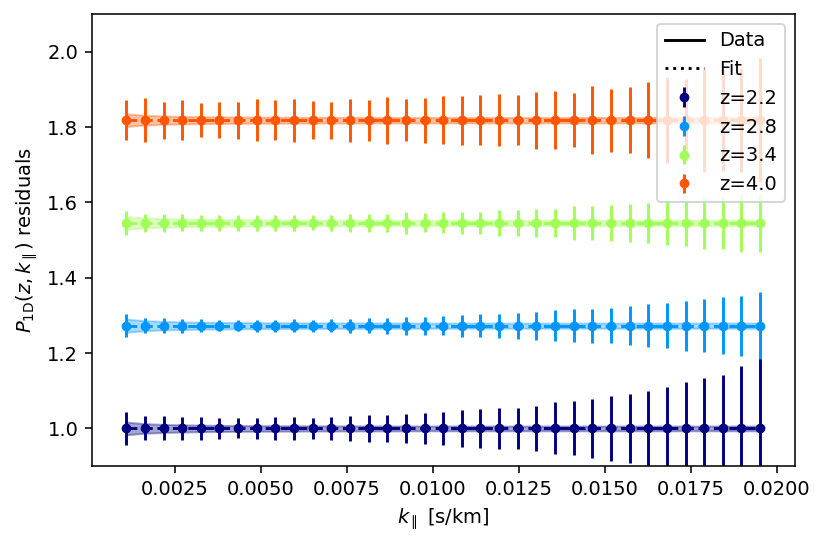

In [10]:
# check starting point for free parameters (should be equal to truth)
test_values=len(free_param_names)*[0.5]
for p in like.parameters_from_sampling_point(values=test_values):
    print(p.info_str(all_info=True))
print('chi2 =',like.get_chi2(values=test_values))
like.plot_p1d(values=test_values,residuals=True,plot_every_iz=3)

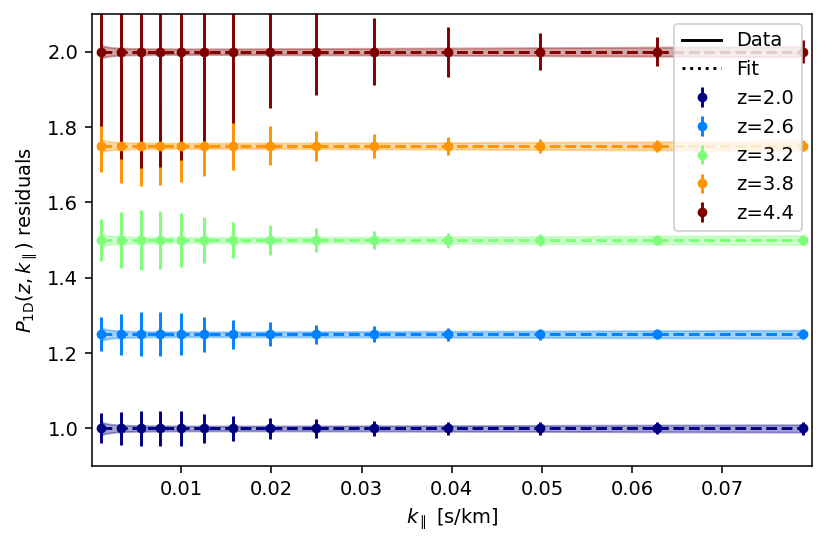

In [11]:
if extra_data:
    like.extra_p1d_like.plot_p1d(residuals=True,plot_every_iz=3)

### Run iminuit minimizer

In [12]:
# choose starting point for free parameters (within 0.5 +/- ini_sigma, in the unit cube)
ini_sigma=0.1
ini_values=2*ini_sigma*np.random.random(len(like.free_params))+0.5-ini_sigma
print('ini values',ini_values)
for p in like.parameters_from_sampling_point(values=ini_values):
    print(p.info_str(all_info=True))

ini values [0.52534897 0.45166237 0.45717249 0.46745142 0.46785596 0.5013758
 0.44162418 0.43825847 0.44483934 0.45633467]
As = 2.1557677326555437e-09 , 1e-09 , 3.2e-09
ns = 0.9567826035662184 , 0.88 , 1.05
ln_tau_0 = -0.008565501177969573 , -0.1 , 0.1
ln_sigT_kms_0 = -0.026038866023833762 , -0.4 , 0.4
ln_gamma_0 = -0.012857614440676512 , -0.2 , 0.2
ln_kF_0 = 0.0005503202136697138 , -0.2 , 0.2
ln_tau_1 = -0.023350327745236266 , -0.2 , 0.2
ln_sigT_kms_1 = -0.04939322365003285 , -0.4 , 0.4
ln_gamma_1 = -0.044128524921621115 , -0.4 , 0.4
ln_kF_1 = -0.034932267341063916 , -0.4 , 0.4


In [13]:
minimizer = iminuit_minimizer.IminuitMinimizer(like,ini_values=ini_values)

In [14]:
minimizer.minimize(compute_hesse=True)

In [15]:
# what is the chi2 of the best-fit? (should be close to 0)
best_fit_values=np.array(minimizer.minimizer.values)
like.get_chi2(values=best_fit_values)

2.8399700394254407e-08

In [16]:
# what was the chi2 of the starting point?
like.get_chi2(values=ini_values)

46.68465790327619

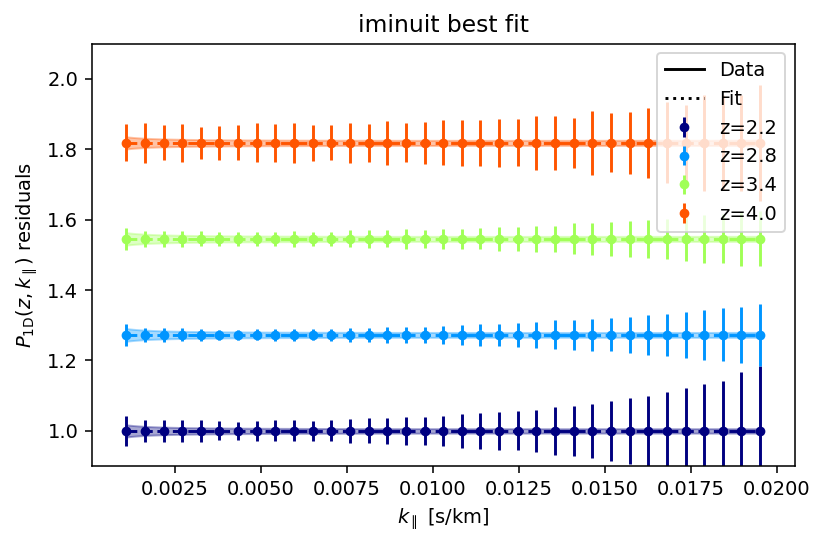

In [17]:
minimizer.plot_best_fit(plot_every_iz=3)

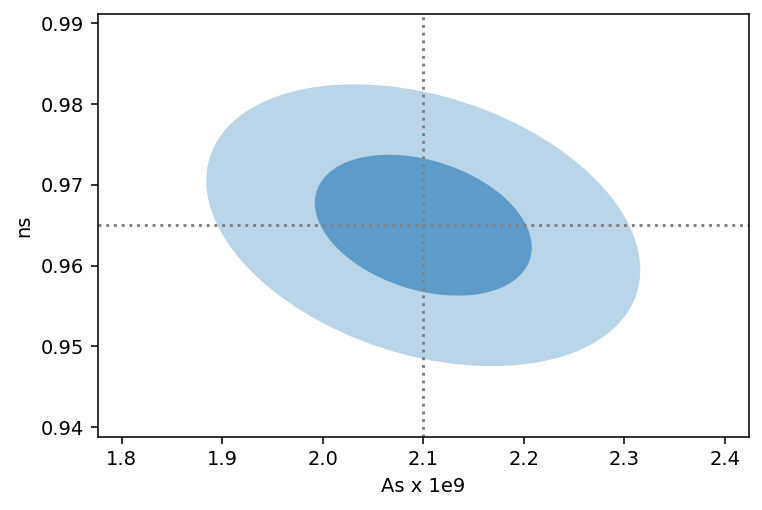

In [18]:
minimizer.plot_ellipses('As','ns')

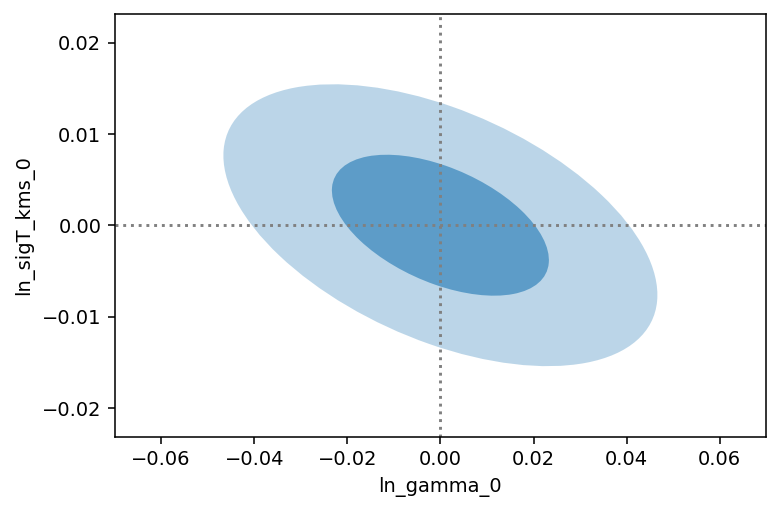

In [19]:
minimizer.plot_ellipses('ln_gamma_0','ln_sigT_kms_0')

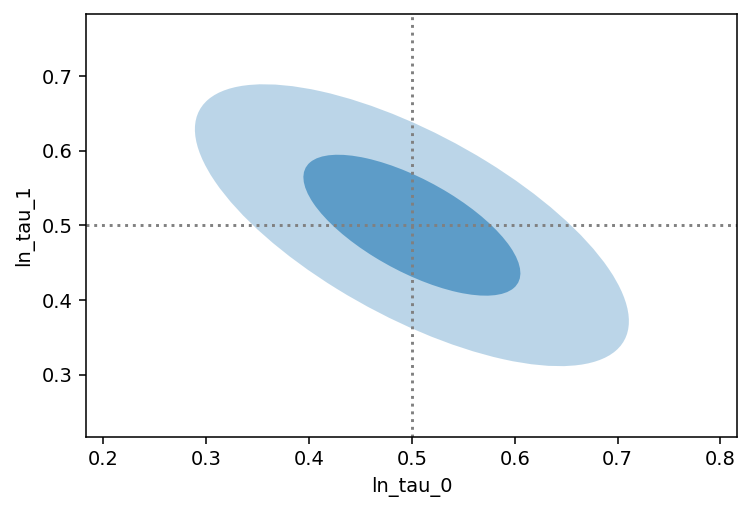

In [20]:
minimizer.plot_ellipses('ln_tau_0','ln_tau_1',cube_values=True)

In [21]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 51.26                      │              Nfcn = 675              │
│ EDM = 8.01e-12 (Goal: 0.0001)    │           time = 70.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.50    │   0.05    │            │            │         │         │       │
│ 1 │ x1   │   0.50    │   0.05    │            │            │         │         │       │
│ 2 │ x2   │    0.5    │    0.1    │            │            │         │         │       │
│ 3 │ x3   │   0.50    │   0.01    │            │            │         │         │       │
│ 4 │ x4   │   0.50    │   0.06    │            │            │         │         │       │
│ 5 │ x5   │   0.50    │   0.12    │            │            │         │         │       │
│ 6 │ x6   │   0.50    │   0.09    │            │            │         │         │       │
│ 7 │ x7   │   0.50    │   0.06    │            │            │         │         │       │
│ 8 │ x8   │   0.50    │   0.07    │            │            │         │         │       │
│ 9 │ x9   │   0.50    │   0.12    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │   0.00237 -0.000784  -0.00487 -9.25e-05  -0.00204   0.00494   0.00301   0.00116 -0.000318  -0.00279 │
│ x1 │ -0.000784   0.00262   0.00116  -8.6e-05    0.0011  -0.00366  -0.00101  -0.00145   0.00184 -0.000909 │
│ x2 │  -0.00487   0.00116     0.011 -2.75e-05   0.00526     -0.01  -0.00674  -0.00171  0.000556   0.00512 │
│ x3 │ -9.25e-05  -8.6e-05 -2.75e-05  9.28e-05 -0.000283 -0.000143  3.32e-05 -0.000195 -0.000113  0.000669 │
│ x4 │  -0.00204    0.0011   0.00526 -0.000283   0.00341  -0.00448  -0.00344 -0.000248  0.000782  0.000512 │
│ x5 │   0.00494  -0.00366     -0.01 -0.000143  -0.00448     0.014   0.00511   0.00509  -0.00345  -0.00484 │
│ x6 │   0.00301  -0.00101  -0.00674  3.32e-05  -0.00344   0.00511   0.00889 -0.000999   0.00284  -0.00727 │
│ x7 │   0.00116  -0.00145  -0.00171 -0.000195 -0.000248   0.00509 -0.000999   0.00395  -0.00309 -0.000533 │
│ x8 │ -0.000318   0.00184  0.000556 -0.000113  0.000782  -0.00345   0.00284  -0.00309   0.00453  -0.00373 │
│ x9 │  -0.00279 -0.000909   0.00512  0.000669  0.000512  -0.00484  -0.00727 -0.000533  -0.00373    0.0149 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [22]:
minimizer.minimizer.errors

<ErrorView x0=0.04871833884799008 x1=0.05122562493770185 x2=0.10510052486203603 x3=0.009634861478044947 x4=0.058377080841295746 x5=0.11829590754957288 x6=0.09428839018418349 x7=0.06287514788338919 x8=0.06727424843882045 x9=0.12219152148973397>

In [23]:
minimizer.best_fit_value('ln_tau_0',return_hesse=True)

(8.067064967420823e-08, 0.021020104972407208)